**Import all required module**

In [ ]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import tarfile
import requests
from zipfile import ZipFile
import os
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint

**Download and extract data**

In [ ]:
data_url = "https://arjunaskykok.s3.ap-southeast-1.amazonaws.com/support/kagglecatsanddogs_3367a.zip"
data = requests.get(data_url, allow_redirects=True)
open('PetImages.zip', 'wb').write(data.content)
with ZipFile('PetImages.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

**Data cleansing**

The zip file contains some badly-encoded images that do not feature the string "JFIF" in their header. These files need to be removed.

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


**Split datasets into training and testing subsets**

In [ ]:
image_size = (180, 180)
batch_size = 32

dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
  'PetImages',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
  'PetImages',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


**Get class names from dataset**

In [ ]:
class_names = dataset_train.class_names
print(class_names)

['Cat', 'Dog']


**Show data samples to check the contents of the data**

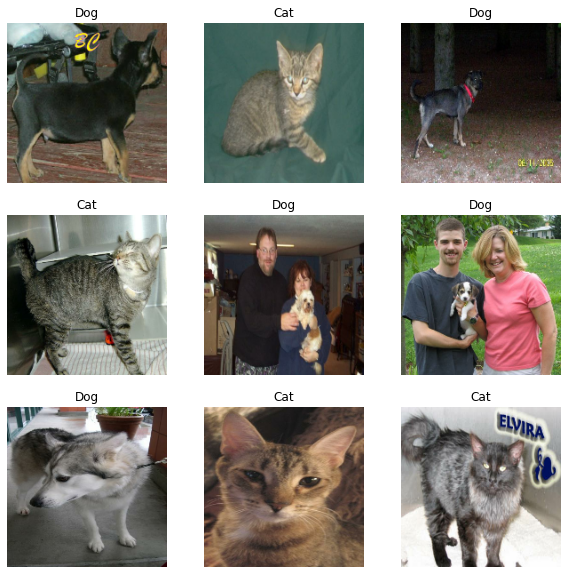

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in dataset_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Check data dimensions**

In [ ]:
for image_batch, labels_batch in dataset_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


**Prepare normalization layer**

In [ ]:
# normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalization_layer = keras.Sequential(
    [
      layers.experimental.preprocessing.Rescaling(1.0 / 255)
    ]
)

**Prepare augmentation layer**


Augment data with random flip/rotation to make data more diverse

In [ ]:
data_augmentation_layer = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

**Show example of augmented images**

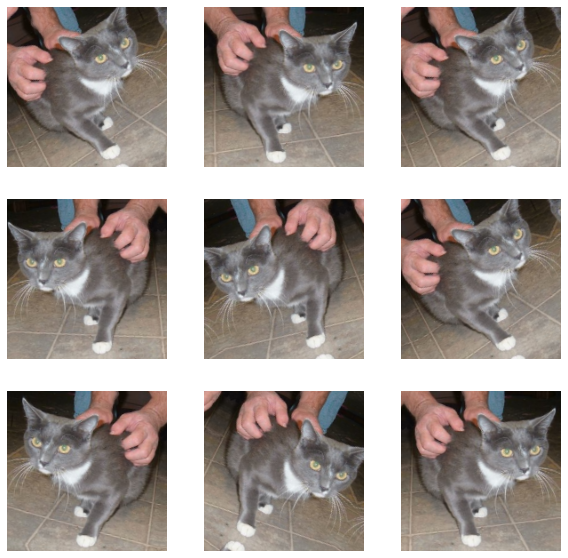

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in dataset_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation_layer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Prefetch data to improve dataset performance**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

dataset_train = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.cache().prefetch(buffer_size=AUTOTUNE)

**Define Model**

Make sure to include normalization and augmentation layer for data preprocessing to avoid overfitting

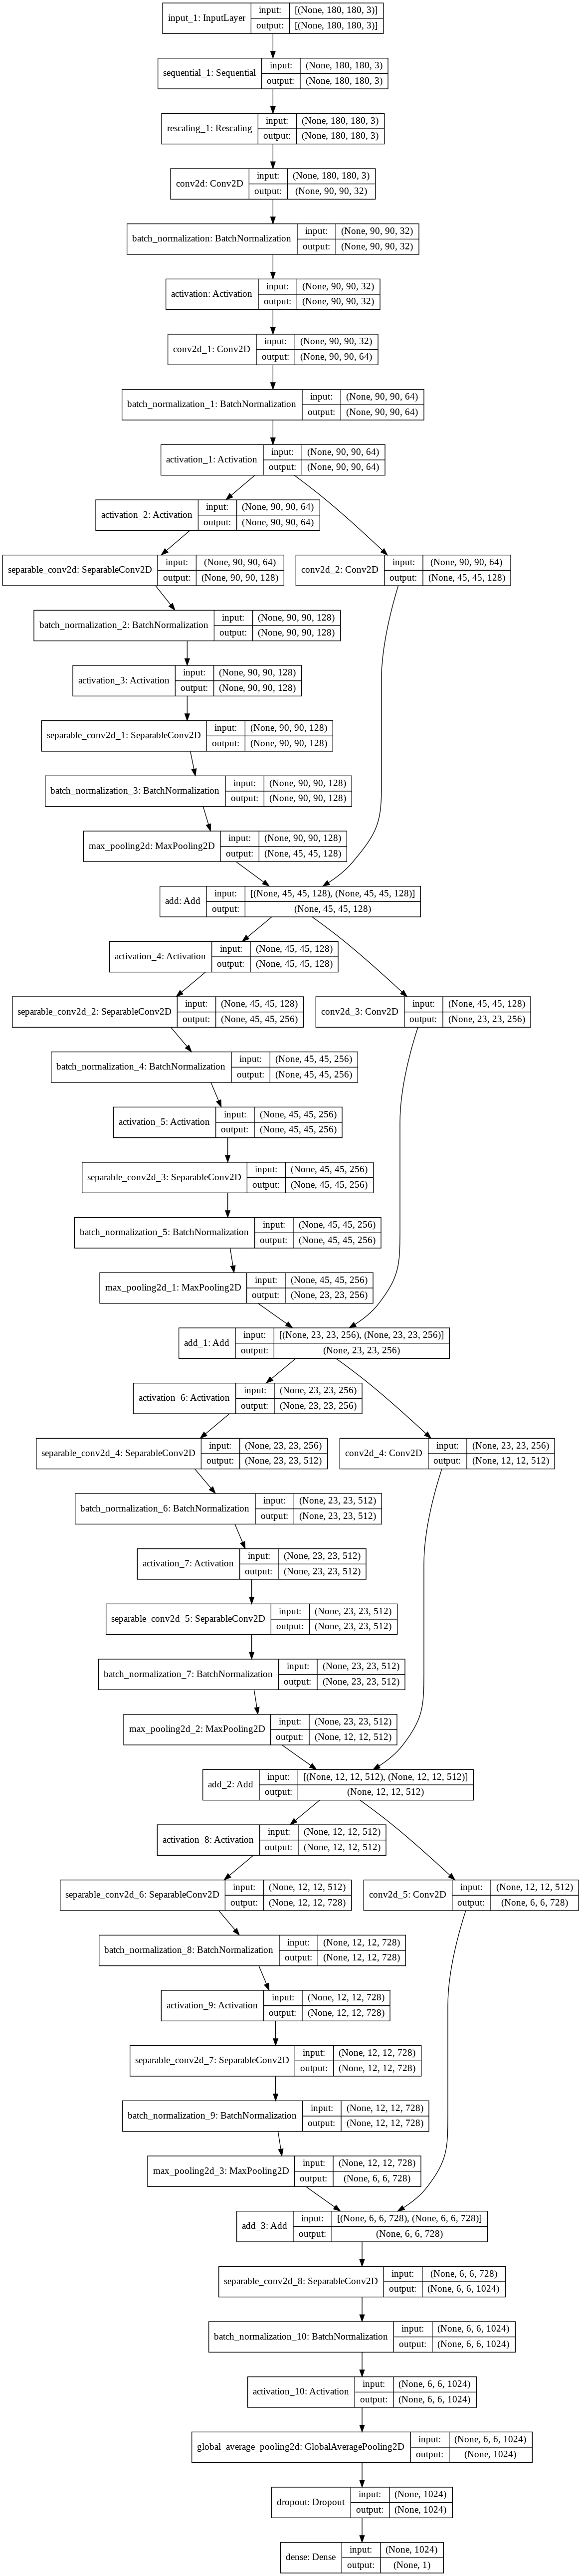

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation_layer(inputs)

    # Entry block
    # x = normalization_layer(x)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

**Compile & train model**

Add checkpointer to monitor loss improvement in each epoch

In [ ]:
checkpointer = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(dataset_train,
          epochs=10,
          validation_data=dataset_test,
          callbacks=[checkpointer])

Epoch 1/10
586/586 [==============================] - 200s 281ms/step - loss: 0.6591 - accuracy: 0.6276 - val_loss: 0.5787 - val_accuracy: 0.6924


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
586/586 [==============================] - 847s 1s/step - loss: 0.5312 - accuracy: 0.7362 - val_loss: 0.5570 - val_accuracy: 0.7413
Epoch 3/10
586/586 [==============================] - 856s 1s/step - loss: 0.4466 - accuracy: 0.7940 - val_loss: 0.4122 - val_accuracy: 0.8133
Epoch 4/10
586/586 [==============================] - 874s 1s/step - loss: 0.3633 - accuracy: 0.8410 - val_loss: 0.4423 - val_accuracy: 0.8225
Epoch 5/10
586/586 [==============================] - 906s 2s/step - loss: 0.2966 - accuracy: 0.8741 - val_loss: 0.3648 - val_accuracy: 0.8368
Epoch 6/10
586/586 [==============================] - 910s 2s/step - loss: 0.2480 - accuracy: 0.8973 - val_loss: 0.2861 - val_accuracy: 0.8753
Epoch 7/10
586/586 [==============================] - 917s 2s/step - loss: 0.2151 - accuracy: 0.9123 - val_loss: 0.4998 - val_accuracy: 0.7819
Epoch 8/10
586/586 [==============================] - 924s 2s/step - loss: 0.1975 - accuracy: 0.9196 - val_loss: 0.3649 - val_accuracy: 0.8578

**Check training accuracy**

In [ ]:
Accuracy = model.evaluate(dataset_test, verbose=0)

print('\n', 'Test accuracy:', Accuracy[1])


 Test accuracy: 0.846433162689209


**Try the model to predict the category of an image**

This is an image of a Cat


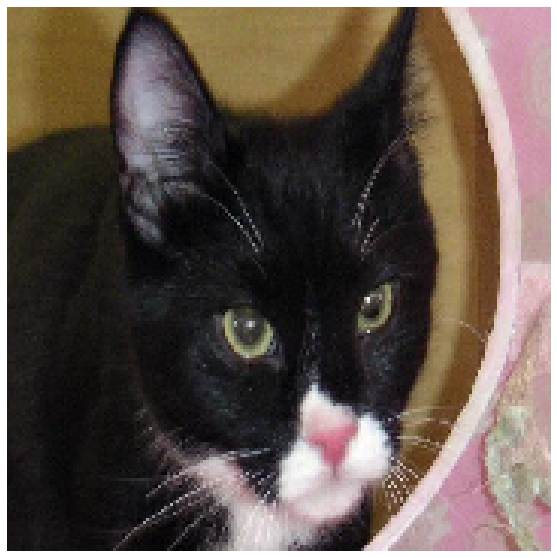

In [ ]:
image_size = (180,180)
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/10001.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")

predictions = model.predict(img_array)
score = predictions[0]
score = np.round(score,0)
category = class_names[int(score[0])]
print("This is an image of a " + str(category))
# print(
#     "This image is %.2f percent cat and %.2f percent dog."
#     % (100 * (1 - score), 100 * score)
# )